<h1 style="text-align: center; color: black;" markdown="1">MATH 385 Final Project </h1>
<h2 style="text-align: center; color: black;" markdown="1">Marco Ren </h2>

First of all, we import the libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ISLP.models import sklearn_sm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor as RF
import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skm
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

We then load the datasets.

In [3]:
df = pd.read_csv("housing.csv")
df.dropna(inplace=True)
df_Selected = df.copy()

location_map = {'NEAR BAY': 1, '<1H OCEAN': 2, 'INLAND': 3, 'NEAR OCEAN': 4, 'ISLAND': 5}
df_Selected['ocean_proximity'] = df_Selected['ocean_proximity'].map(location_map)
df_Selected

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,1
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,1
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,1
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,1
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,3
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,3
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,3
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,3


#### Data Exploration

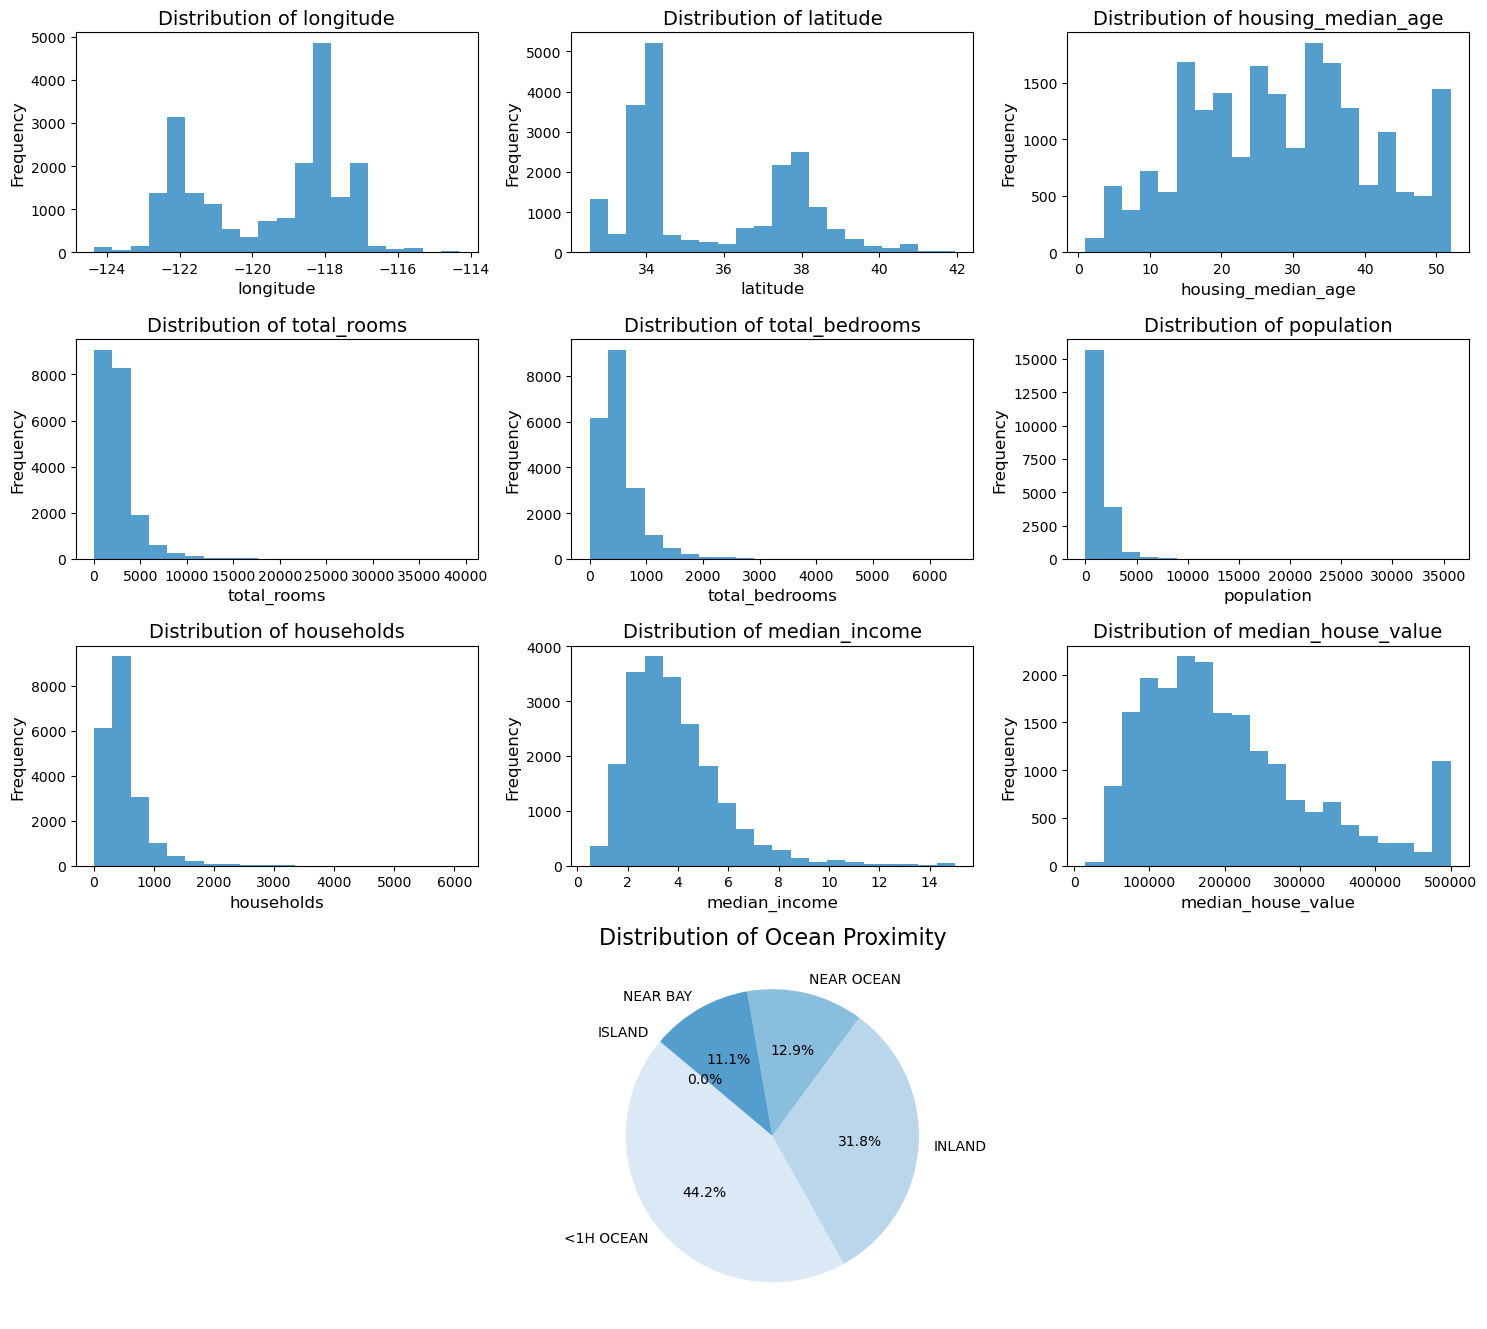

In [4]:
numerical_vars = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 
                  'total_bedrooms', 'population', 'households', 'median_income',
                  'median_house_value']
categorical_vars = ['ocean_proximity']

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 3, figure=fig, height_ratios=[3, 3, 3, 5, 1])


axes = []
for i, var in enumerate(numerical_vars):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    axes.append(ax)
    ax.hist(df[var], bins=20, color=sns.color_palette("Blues")[3])
    ax.set_title(f'Distribution of {var}', fontsize=14)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

ax_pie = fig.add_subplot(gs[3, :])
location_counts = df['ocean_proximity'].value_counts()
ax_pie.pie(location_counts, labels=location_counts.index, autopct='%1.1f%%', 
           startangle=140, colors=sns.color_palette("Blues"))
ax_pie.set_title('Distribution of Ocean Proximity', fontsize=16)

plt.tight_layout()
plt.show()

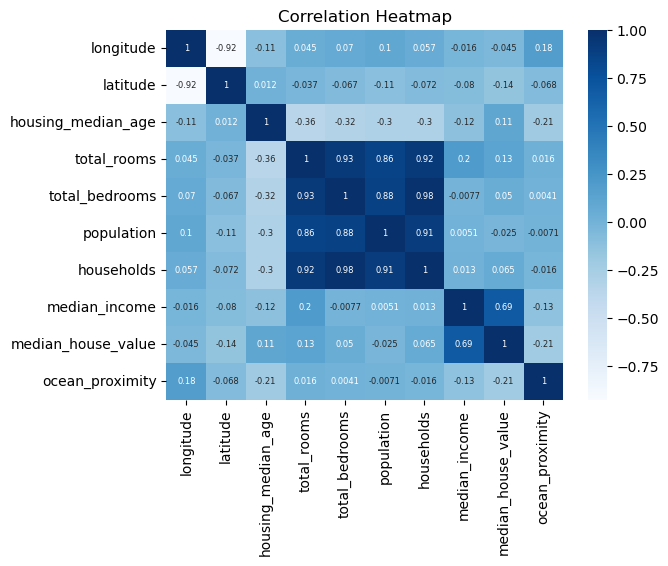

In [7]:
corr_matrix = df_Selected.corr()
sns.heatmap(corr_matrix, cmap='Blues', annot = True,  annot_kws={"size": 6})
plt.title("Correlation Heatmap")

plt.show()

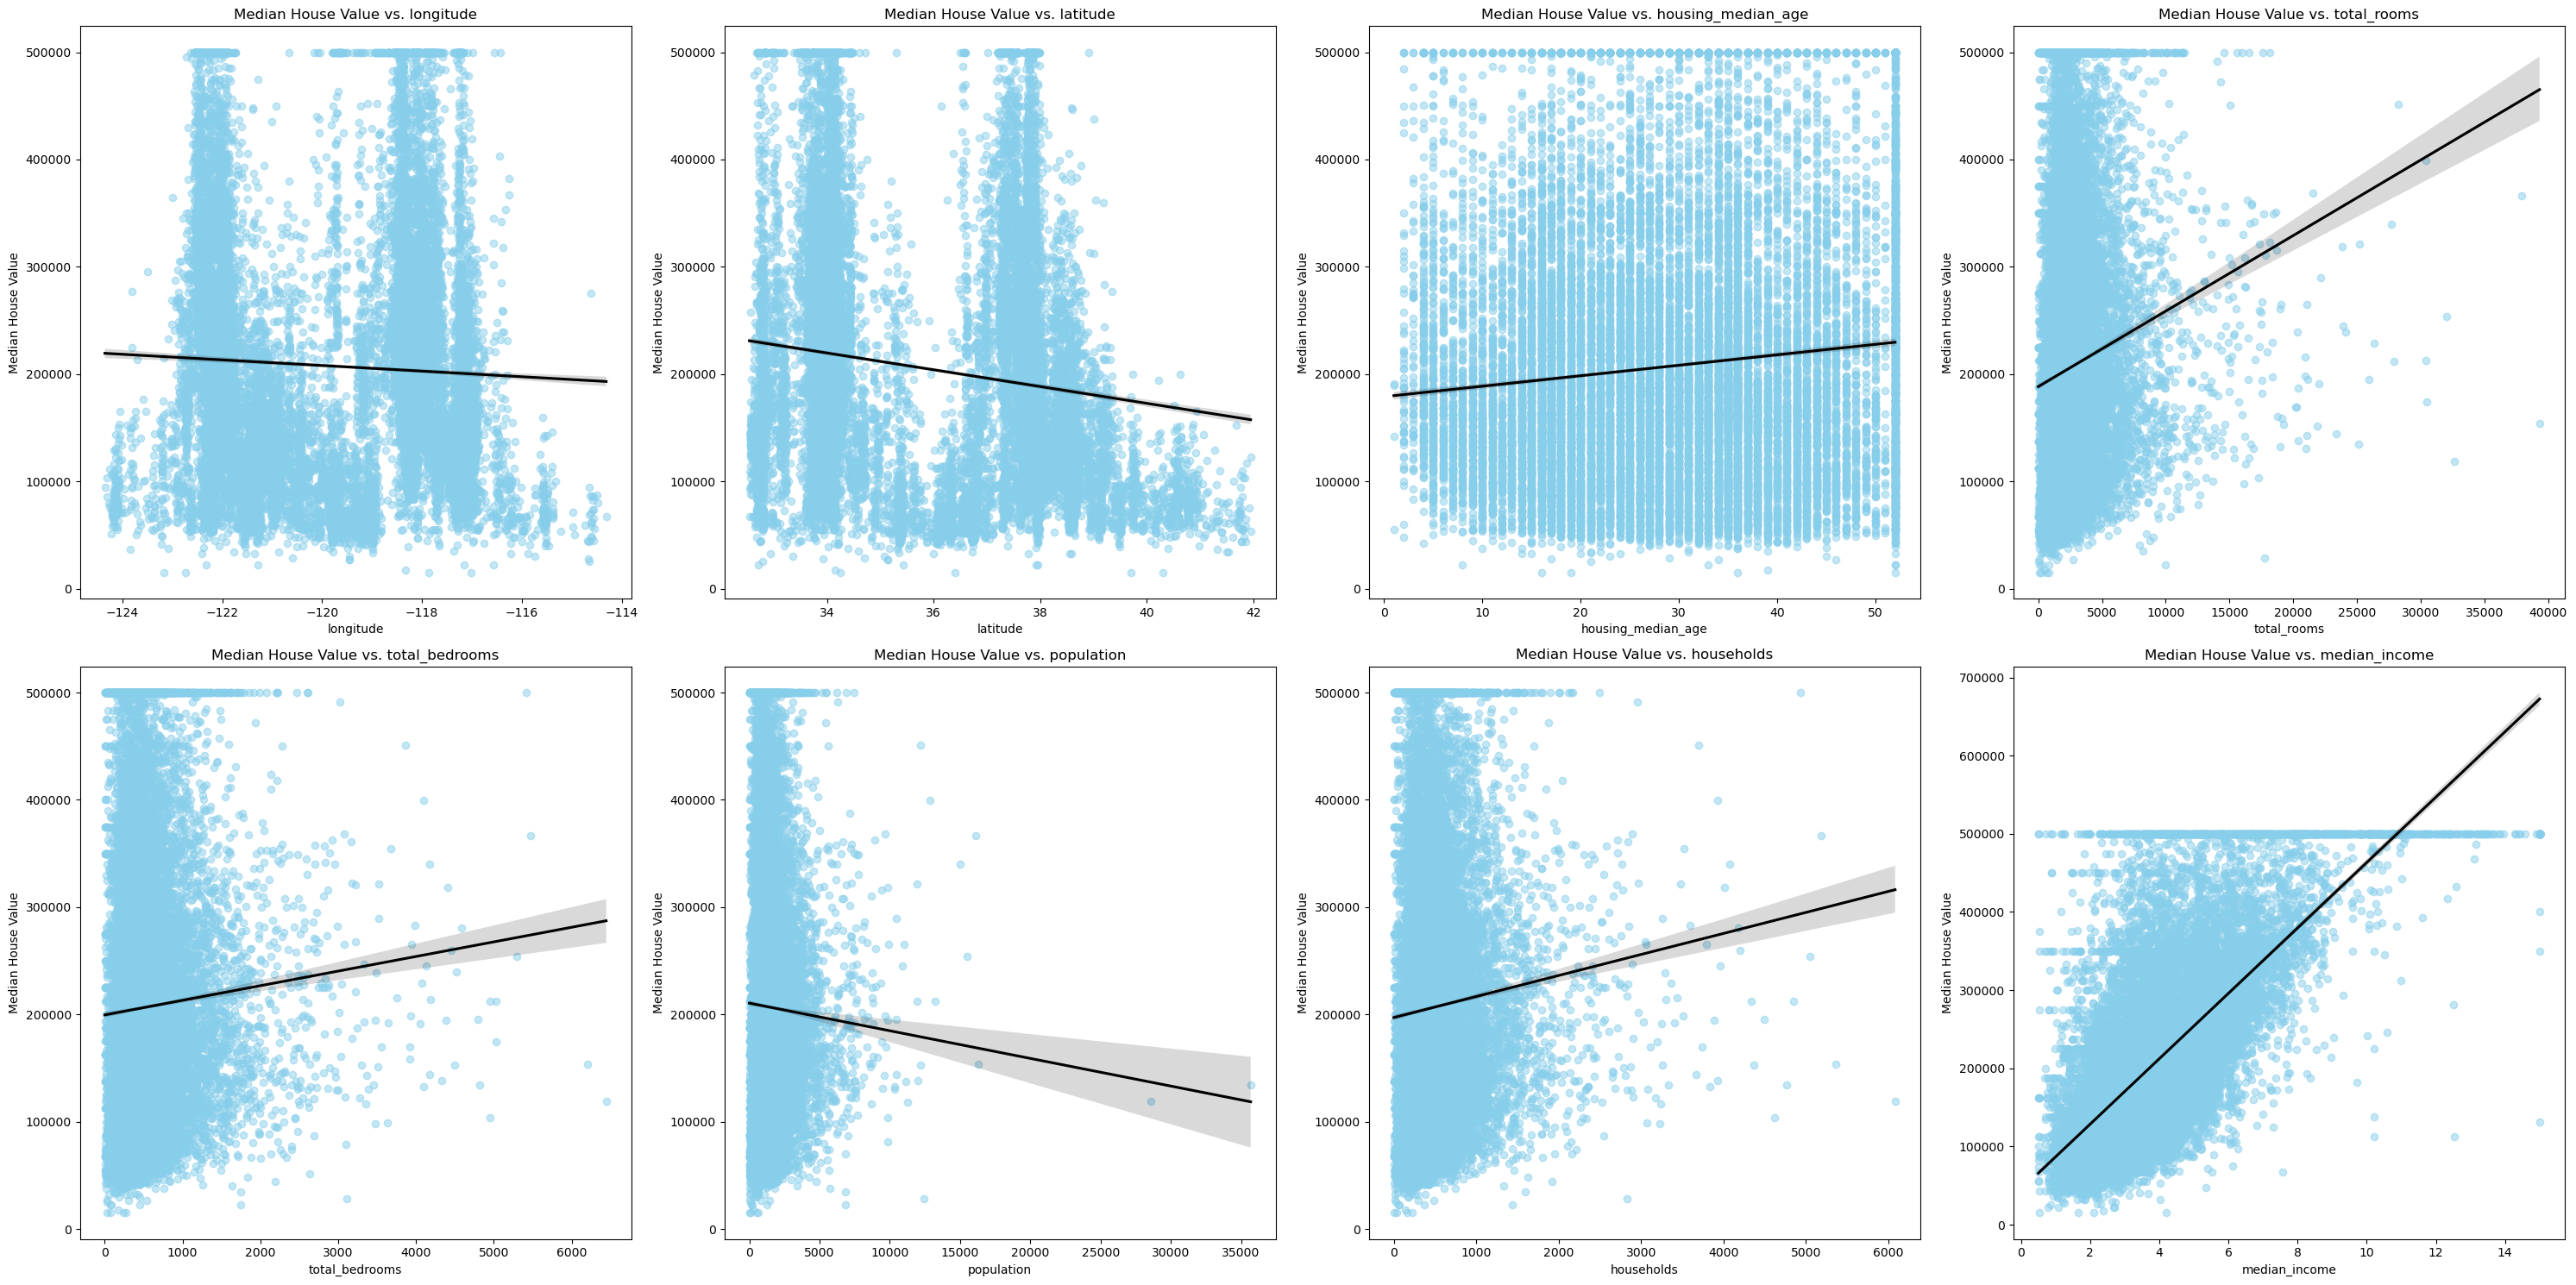

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(30, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_vars[0:8]):
    sns.regplot(data=df_Selected, x=col, y='median_house_value', 
                scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'}, 
                color='skyblue', ax=axes[i])
    axes[i].set_title(f"Median House Value vs. {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Median House Value")

plt.tight_layout()
plt.show()

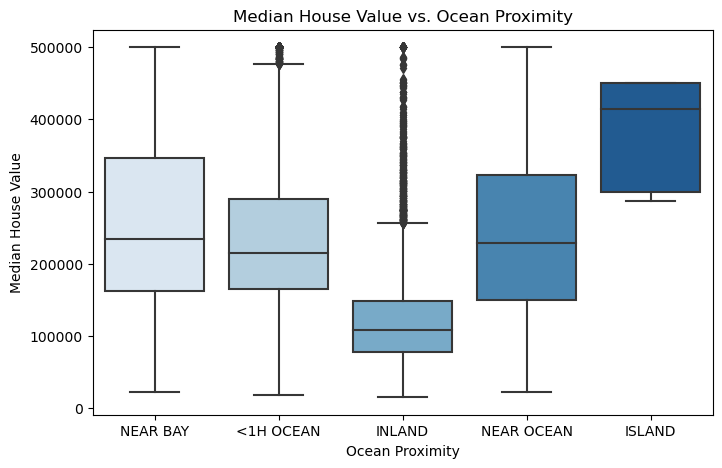

In [8]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='ocean_proximity', y='median_house_value', palette='Blues')
plt.title("Median House Value vs. Ocean Proximity")
plt.xlabel("Ocean Proximity")
plt.ylabel("Median House Value")
plt.show()

#### OLS

In [4]:
X = df_Selected.drop(['median_house_value'], axis=1).astype('float64')
y = df_Selected['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

In [5]:
X_train_con = sm.add_constant(X_train)
X_test_con = sm.add_constant(X_test)
model_OLS = sm.OLS(y_train, X_train_con).fit()
print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     3173.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:40:09   Log-Likelihood:            -2.0546e+05
No. Observations:               16346   AIC:                         4.109e+05
Df Residuals:                   16336   BIC:                         4.110e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -3.55e+06   7.28

In [11]:
y_test_pred = model_OLS.predict(X_test_con)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("Test RMSE:", test_rmse)

Test RMSE: 69274.95173165193


#### Regression Tree

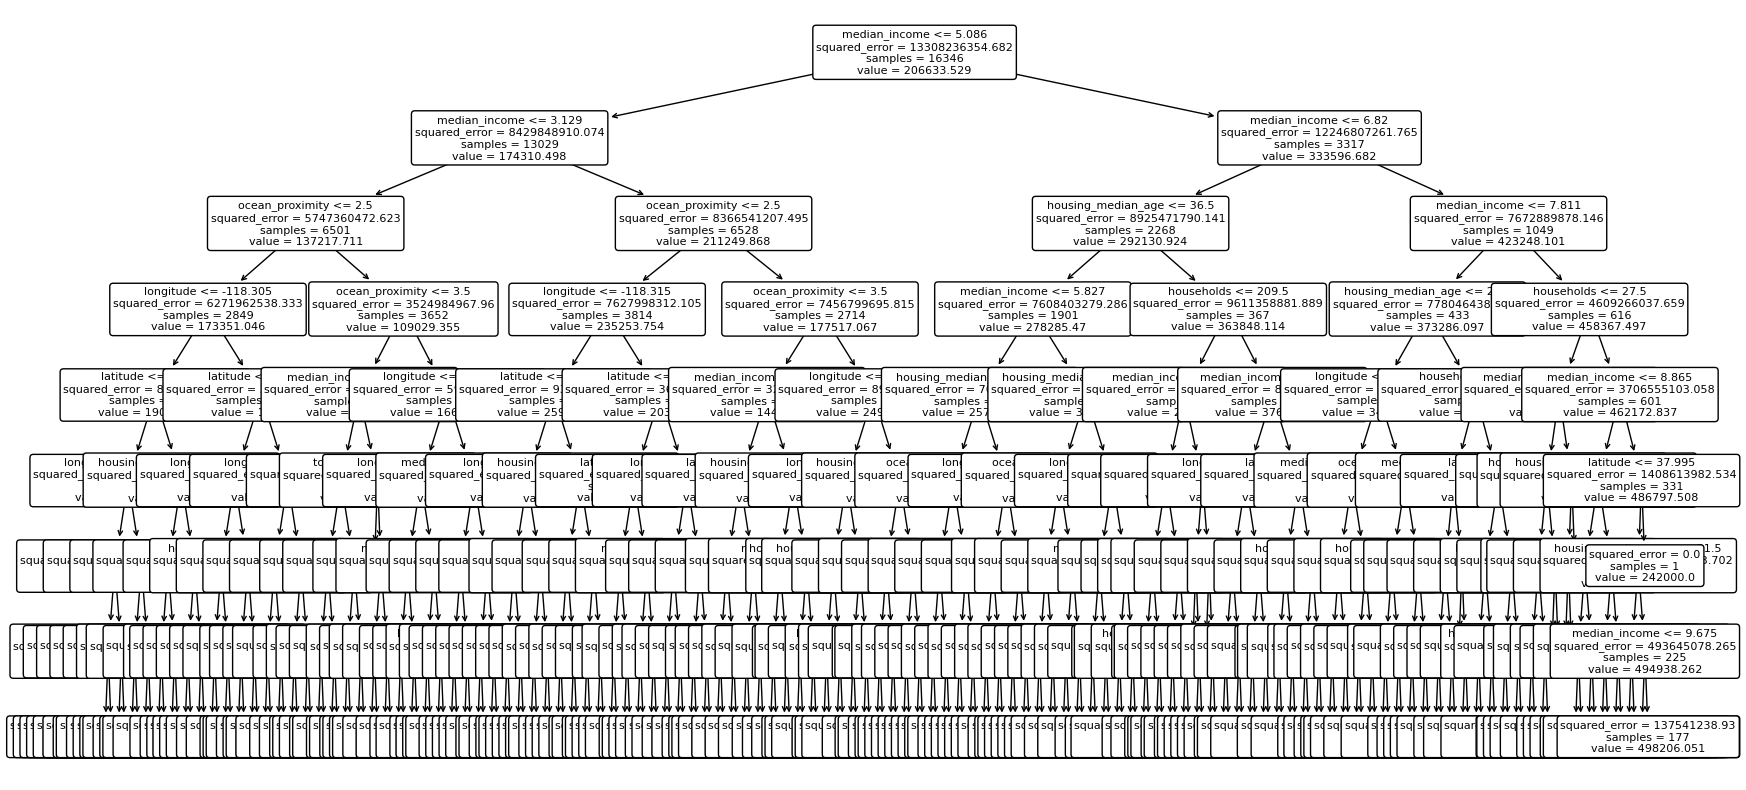

In [211]:
reg = DecisionTreeRegressor(random_state=0, max_depth=8)
reg.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(reg, feature_names=X.columns, rounded=True, fontsize=8)
plt.show()

In [212]:
y_test_pred = reg.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("Test RMSE:", test_rmse)

Test RMSE: 62437.855485451815


#### Gradient Boosting

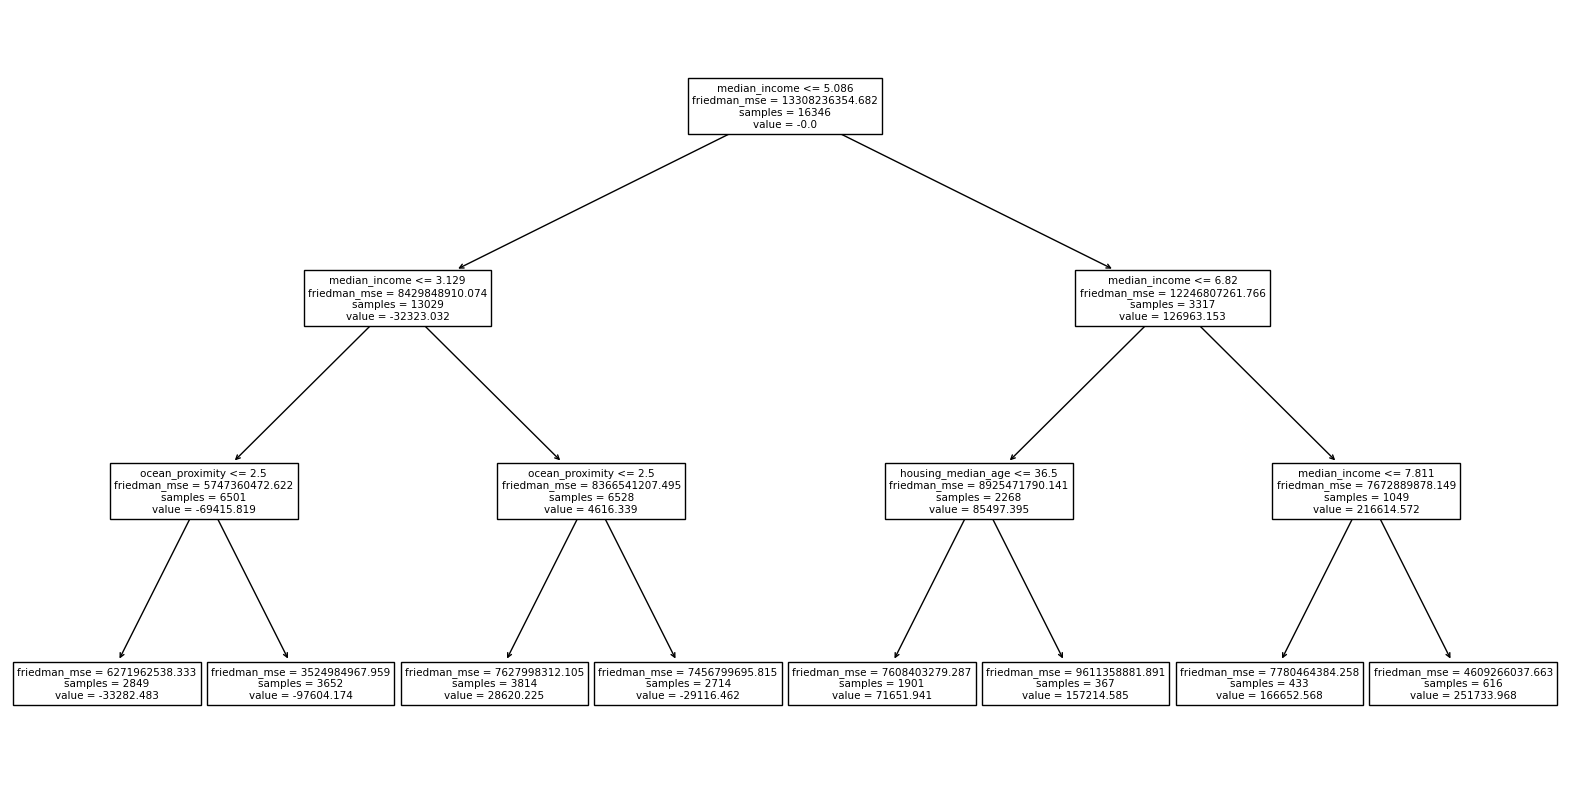

In [181]:
boost = GBR(n_estimators=1800,
            learning_rate=0.5,
            max_depth=3,
            subsample=1,
            random_state=0)
boost.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(boost.estimators_[0, 0], feature_names=X.columns)
plt.show()

In [182]:
y_test_pred = boost.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("Test RMSE:", test_rmse)

Test RMSE: 50552.05389585183


#### Gradient Boosting (Subsampling)

In [183]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

param_grid = {'subsample': [0.9, 0.925, 0.95, 0.975]}

grid = GridSearchCV(GBR(n_estimators=1800,
                        learning_rate=0.5, 
                        max_depth=3,
                        random_state=0), 
                    param_grid, 
                    cv=kfold)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'subsample': 0.975}


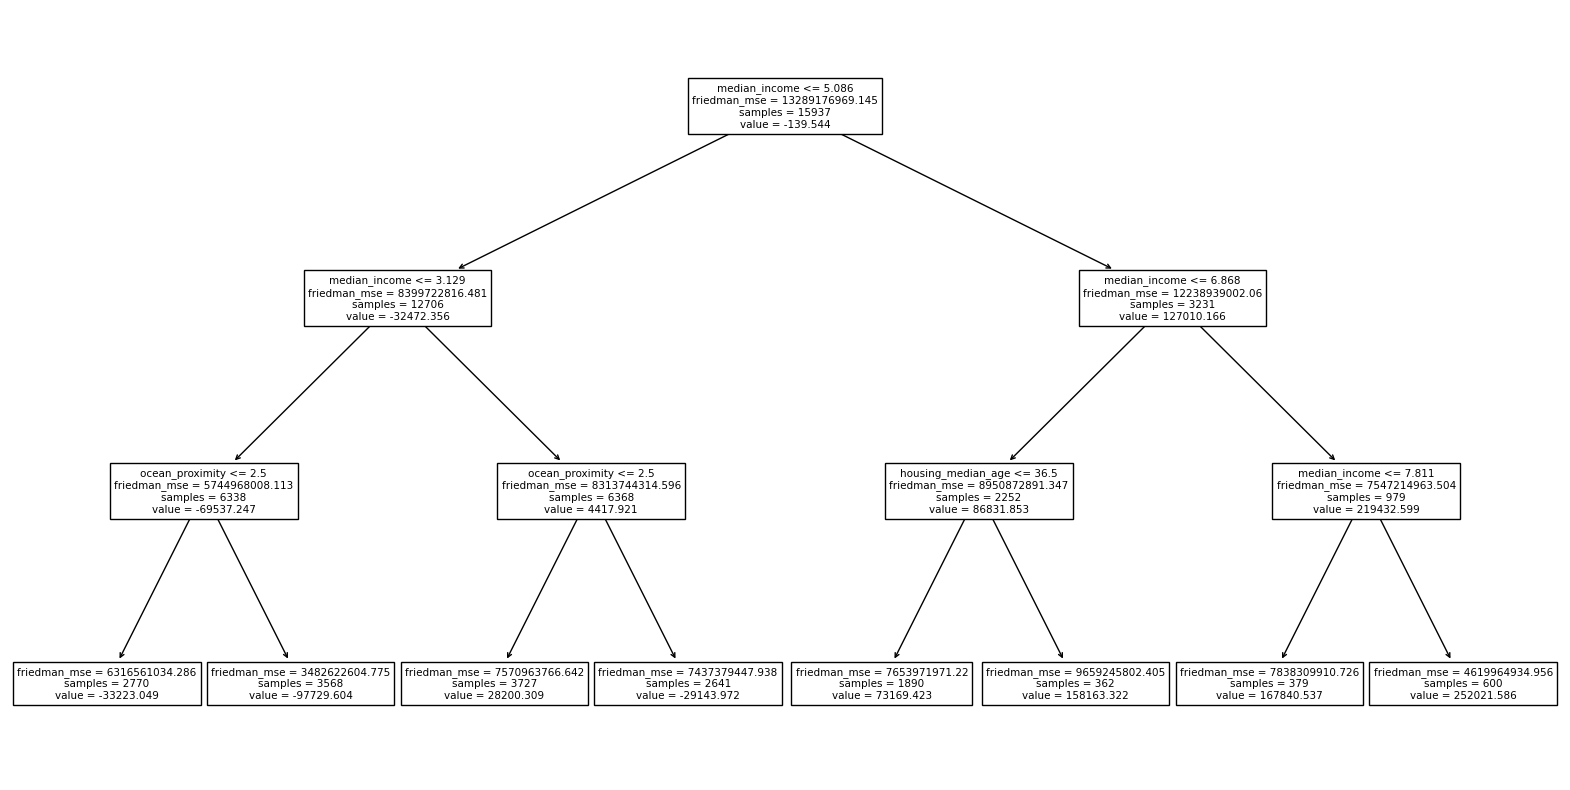

In [184]:
boost_subsample = GBR(n_estimators=1800,
                      learning_rate=0.5, 
                      max_depth=3,
                      subsample=0.975,
                      random_state=0)
boost_subsample.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(boost_subsample.estimators_[0, 0], feature_names=X.columns)
plt.show()

In [185]:
y_test_pred = boost_subsample.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("Test RMSE:", test_rmse)

Test RMSE: 50110.97735053087


#### Gradient Boosting (Shrinkage)

In [186]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

param_grid = {'learning_rate': [0.1, 0.2, 0.3, 0.4]}

grid = GridSearchCV(GBR(n_estimators=1800,
                        max_depth=3,
                        subsample=1,
                        random_state=0), 
                    param_grid, 
                    cv=kfold)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'learning_rate': 0.1}


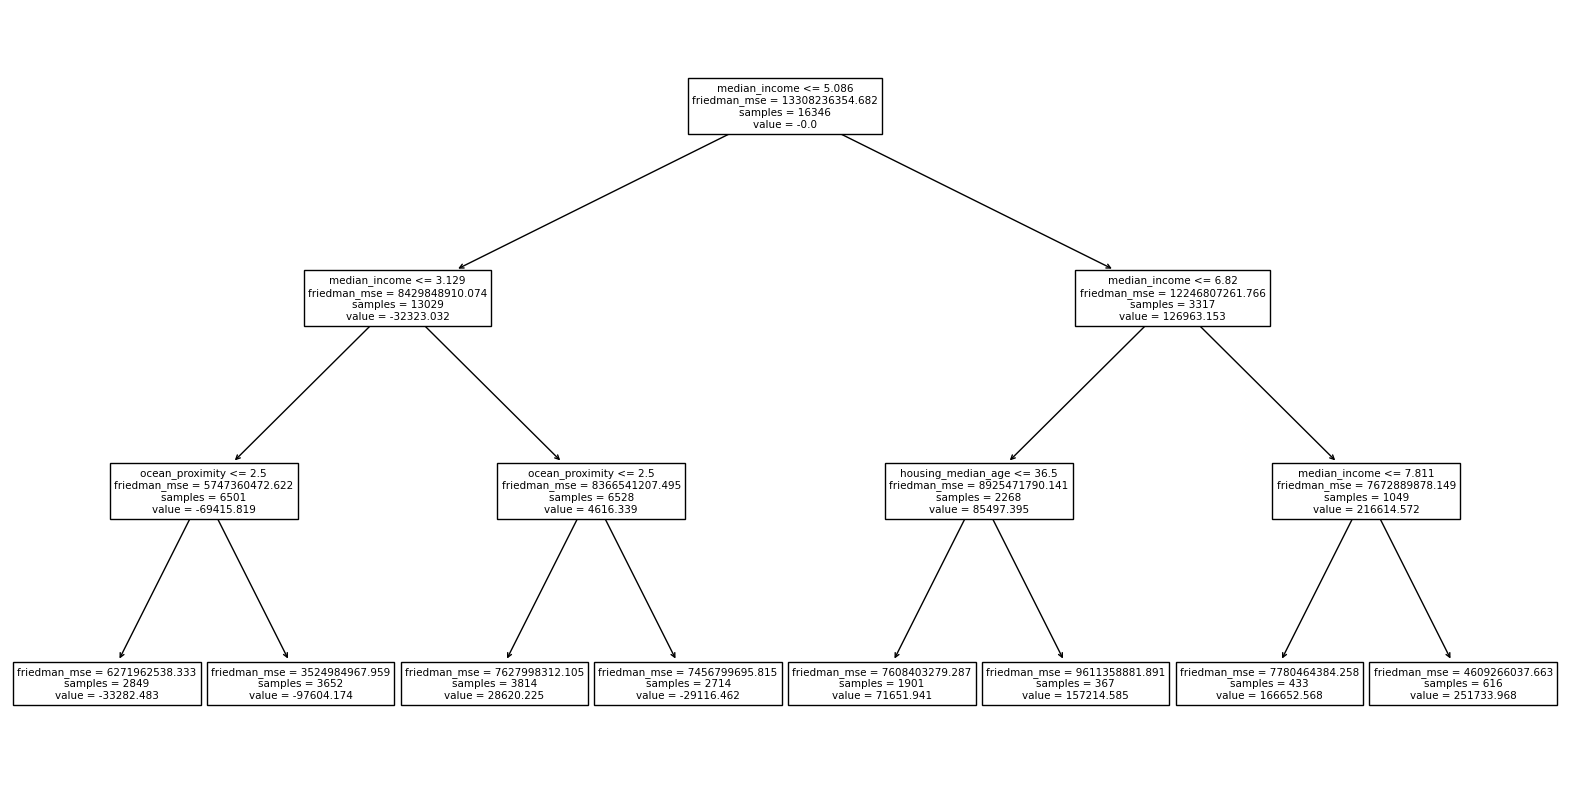

In [193]:
boost_shrinkage = GBR(n_estimators=1800,
                      learning_rate=0.1, 
                      max_depth=3,
                      subsample=1,
                      random_state=0)
boost_shrinkage.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(boost_shrinkage.estimators_[0, 0], feature_names=X.columns)
plt.show()

In [194]:
y_test_pred = boost_shrinkage.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("Test RMSE:", test_rmse)

Test RMSE: 47408.819726841786


#### Gradient Boosting (Early Stop)

In [189]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

param_grid = {'validation_fraction': [0.1, 0.2],
              'n_iter_no_change': [100, 200, 300],
              'tol': [1e-5, 1e-4]
}

grid = GridSearchCV(GBR(n_estimators=1800,
                        learning_rate=0.5,
                        max_depth=3,
                        subsample=1,
                        random_state=0), 
                    param_grid, 
                    cv=kfold)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'n_iter_no_change': 200, 'tol': 1e-05, 'validation_fraction': 0.1}


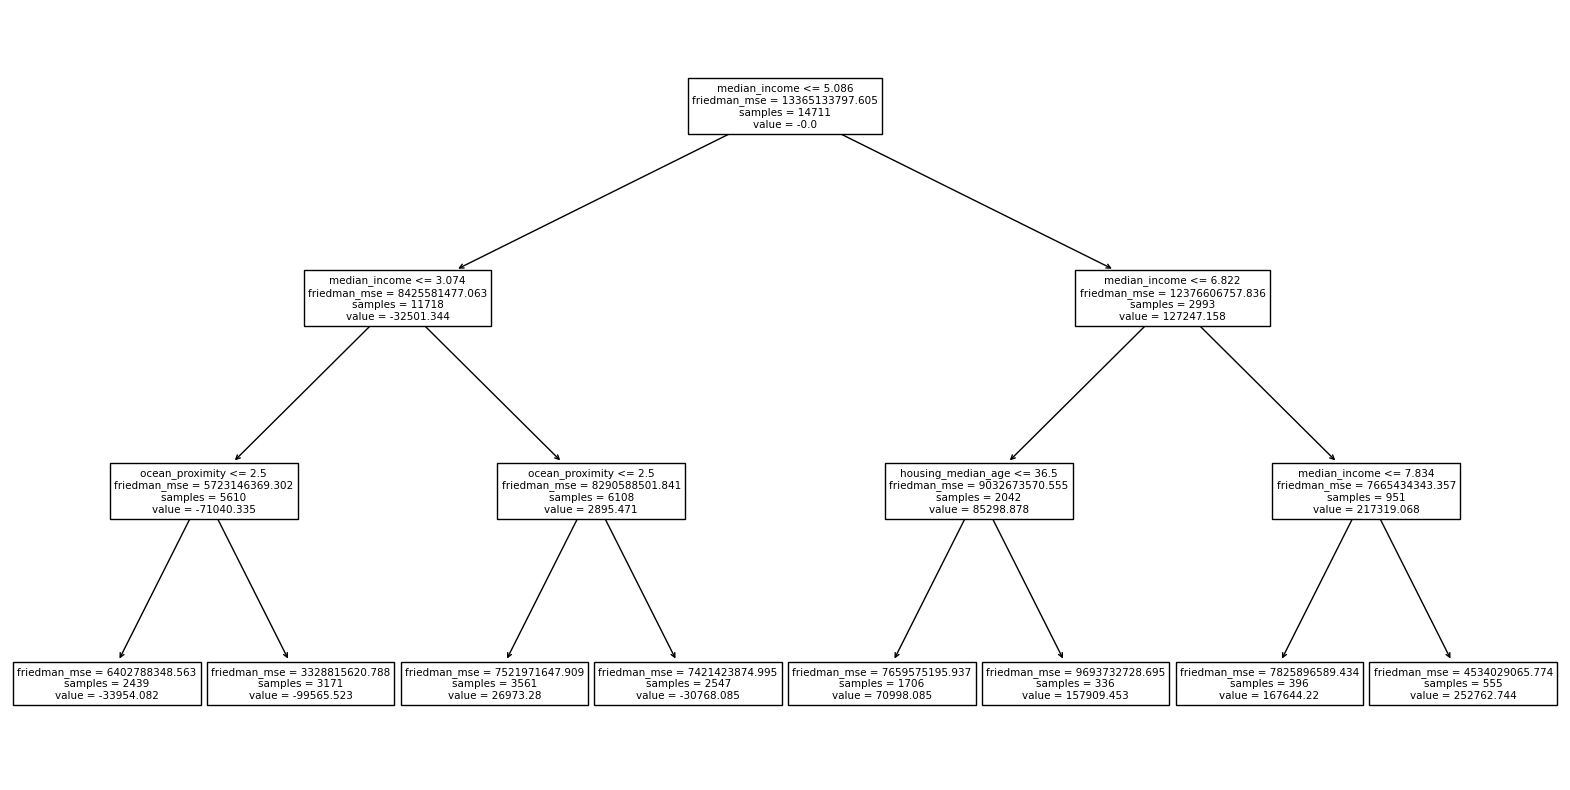

In [5]:
boost_earlystop = GBR(n_estimators=1800,
                      learning_rate=0.5, 
                      max_depth=3,
                      subsample=1,
                      validation_fraction=0.1,
                      n_iter_no_change=200,
                      tol=1e-05, 
                      random_state=0)
boost_earlystop.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(boost_earlystop.estimators_[0, 0], feature_names=X.columns)
plt.show()

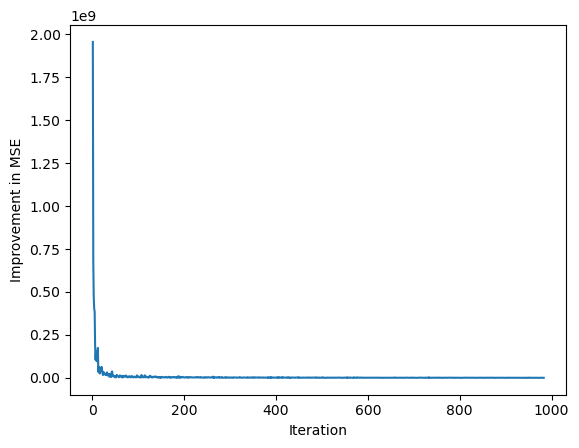

In [7]:
validation_scores = []
for y_pred in boost_earlystop.staged_predict(X_train):
    score = mean_squared_error(y_train, y_pred)
    validation_scores.append(score)
improvements = -np.diff(validation_scores)


plt.plot(range(1, len(improvements) + 1), improvements)
plt.xlabel('Iteration')
plt.ylabel('Improvement in MSE')
plt.show()

In [11]:
y_test_pred = boost_earlystop.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("Test RMSE:", test_rmse)

Test RMSE: 49663.185793394754
